# Read large csv file and count occurances

CSV file is raw holdings file converted from SAS format

File must be transformed into parse matrix

# Import statements

In [215]:
import csv
import collections
import feather
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import sparse
import numpy as np

In [216]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from data.basic_functions import * 

# Find all unqiue Stocks and Portfolio/dates

In [217]:
def make_port_id(a,b):
    """
    Generate a unique ID from the portno and the date of a fund/date combination
    
    Input:
    - a: port_no
    - b: date
    
    Output:
    - port_ID
    """
    return int(100000 * a + b)


In [218]:
# Simple version
def extra_reader(reader_object):
    """
    Loops over rows of holdings csv
    Nedded to generate sparse matrix
    
    Input: 
    - a reader object linking to the holdings csv
    
    Output: 
    - port_ID: Collection of all unique fund/date combinations
    - stock_ID: Collection of all unique stocks
    """
    
    next(reader)
    stocks = collections.Counter()
    port_ID = collections.Counter()
    
    for row in reader_object:
        port_ID_str = make_port_id(int(float(row[0])),int(float(row[1])))
        port_ID[port_ID_str] += 1
        stocks[int(float(row[7]))] += 1

    return(port_ID,stocks)  

In [219]:
path = '../data/raw/out_s.csv'

input_file = open(path)
reader = csv.reader(input_file, delimiter=',')

In [220]:
%%time
port_ID, stocks = extra_reader(reader)

CPU times: user 3min 33s, sys: 3.75 s, total: 3min 37s
Wall time: 3min 37s


In [221]:
sum(port_ID.values())

49999999

# Create stock and port_no map

In [222]:
def make_unique_dict(counter):
    """
    Used to make a dictionary linking each fund/date combination 
    and each stock to a row/col in the sparse matrix
    
    Input:
    - collections.Counter() object
    
    Output:
    - dictionary
    """
    
    unique_keys = list(counter.keys())
    unique_keys_numbers = list(np.arange(len(unique_keys)))
    counter_map = dict(zip(unique_keys, unique_keys_numbers))
    
    return(counter_map)

In [223]:
stock_map = make_unique_dict(stocks)
port_no_map = make_unique_dict(port_ID)

In [224]:
total_number_rows = sum(list(stocks.values()))
print('Total number of rows in file:  {:,}'.format(total_number_rows))
print('Numer of unique stocks:        {:,}'.format(len(stocks.keys())))
print('Numer of unique portfolios:    {:,}'.format(len(port_no_map.keys())))

Total number of rows in file:  49,999,999
Numer of unique stocks:        785,608
Numer of unique portfolios:    224,257


# Set up sparse matrix

In [225]:
def gen_sparse_data(reader):
    """
    Loop over holdings csv file to collect the data for the sparse matrix
    
    Input:
    - reader: CSV holdings file
    
    Output:
    - sparse_row, sparse_col, sparse_data: three np arrays for the construction of the sparse matrix
    """
    next(reader)
    
    counter = 0
    
    sparse_row = np.zeros(total_number_rows)
    sparse_col = np.zeros(total_number_rows)
    sparse_data = np.zeros(total_number_rows)
    
    for row in reader:
        # Row
        port_ID = make_port_id(int(float(row[0])),int(float(row[1])))
        sparse_row[counter] = port_no_map[port_ID]

        # Col
        stock_num = int(float(row[7]))
        sparse_col[counter] = stock_map[stock_num]

        # Data
        try:
            sparse_data[counter] = float(row[4])
        except: 
            sparse_data[counter] = 0
            
        counter += 1
    
    sparse_row = sparse_row.astype(int)
    sparse_col = sparse_col.astype(int)
    
    return(sparse_row, sparse_col, sparse_data)

In [226]:
path = '../data/raw/out_s.csv'
input_file = open(path)
reader = csv.reader(input_file, delimiter=',')

In [227]:
%%time
sparse_row, sparse_col, sparse_data = gen_sparse_data(reader)

CPU times: user 3min 40s, sys: 3.22 s, total: 3min 43s
Wall time: 3min 44s


# Check for duplicates and drop individual positions larger than 200

In [263]:
data = pd.DataFrame({'row': sparse_row, 'col' : sparse_col, 'data' :sparse_data})

In [270]:
data.shape

(49962431, 3)

### Fist mask: drop duplicates

In [264]:
mask1_duplicates = data.duplicated(subset=['row','col']) == False
data_s = data[mask1_duplicates]

### Second mask: Drop extrem individual values

In [265]:
# Drop observations where data is larger than 200 or smaller than -50 -> mask1
mask2_individual = (data_s['data'] < 150) & (data_s['data'] > -50)
data_s = data_s[mask2_individual]

In [266]:
sparse_row = data_s['row']
sparse_col = data_s['col']
sparse_data = data_s['data']

# Create sparse matrix

In [281]:
sparse_matrix = sparse.csr_matrix((sparse_data, (sparse_row, sparse_col)))
print('{:,}'.format(sparse_matrix.sum()))
sparse_matrix

18,649,248.38187009


<224257x785608 sparse matrix of type '<class 'numpy.float64'>'
	with 49962431 stored elements in Compressed Sparse Row format>

### Third mask: drop extrem portfolios

In [282]:
### Drop portfolios with total percent_tna > 150 or < 150
row_sums = np.array(sparse_matrix.sum(1)).flatten()
mask3_portfolios = (row_sums < 150) & (row_sums > -50)
np.sum(mask3_portfolios)

223341

In [283]:
sparse_matrix = sparse_matrix[mask3_portfolios]
sparse_matrix

<223341x785608 sparse matrix of type '<class 'numpy.float64'>'
	with 39407636 stored elements in Compressed Sparse Row format>

# Create sparse info df with Fund_portno and date for every row of the sparse matrix

In [284]:
def split_port_id(num):
    start1 = int(np.floor(num / 10000))
    start2 = num - start1 * 10000
    return(start1,start2)

In [285]:
%%time
port_no = []
date = []
keys = list(port_no_map.keys())

for port_IDs in keys:
    left_temp, right_temp = split_port_id(port_IDs)
    port_no.append(left_temp)
    date.append(right_temp)
    
date = pd.to_timedelta(date, unit='D') + pd.Timestamp('1960-1-1')

CPU times: user 876 ms, sys: 9.11 ms, total: 885 ms
Wall time: 884 ms


In [286]:
sparse_info = pd.DataFrame(data={'port_no':port_no, 'date':date})

#### Check if dimensions match

In [287]:
sparse_info[mask3_portfolios].shape

(223341, 2)

In [288]:
sparse_matrix.shape

(223341, 785608)

# Save data

In [314]:
path = '../data/interim/stock_map'
stock_map_item = {'item1' : stock_map}
np.save(path,stock_map_item) 

#### Sparse matrix

In [304]:
path = '../data/interim/sparse_matrix'
sparse.save_npz(path, sparse_matrix)

#### Sparse info

In [310]:
path = '../data/interim/sparse_info.feather'
feather.write_dataframe(sparse_info,path)

### Try to calculate more percent_tna values
Not really succesfull
Look for another method or just kill all these values

In [25]:
# Calc tna based on percent_tna and market value
holdings['calc_tna'] = holdings['market_val'] / holdings['percent_tna']

# replace inf in calc_tna with nan (caused by percent_tna = 0)
holdings['calc_tna'] = holdings['calc_tna'].replace([np.inf, -np.inf], np.nan)

In [26]:
# Calc mean calc_tna per fund/date pair
holdings_mean = holdings.groupby(['crsp_portno', 'report_dt'])[['calc_tna']].agg('mean')

# Merge mean calc_tna back into holdings table
holdings_mean = holdings_mean.reset_index()
holdings = holdings.merge(holdings_mean,how='left',on=['crsp_portno', 'report_dt'])

In [27]:
# Calc calc_percent_tna 
holdings['calc_percent_tna'] = holdings['market_val'] / holdings['calc_tna_y']

In [28]:
holdings.loc[holdings['percent_tna'].notnull(),'calc_percent_tna'] = holdings['percent_tna']

In [29]:
holdings.sample(5)

,crsp_portno,report_dt,percent_tna,nbr_shares,market_val,crsp_company_key,calc_tna_x,calc_tna_y,calc_percent_tna
5082428,1001851,2008-12-31,2.849998,535600.0,16962452.00,3011639,5.951741e+06,5.955640e+06,2.849998
6853992,1002274,2008-12-31,0.010000,12859.0,56965.37,3006604,5.696538e+06,4.743573e+06,0.010000
6335195,1002165,2008-10-31,0.040000,816.0,3223.20,3006978,8.058002e+04,8.780679e+04,0.040000
8011418,1002638,2006-03-31,0.022802,47.0,4083.83,3001375,1.791000e+05,1.791001e+05,0.022802
2306116,1001263,2009-12-30,0.640000,17150.0,648784.50,3001776,1.013726e+06,1.013524e+06,0.640000


In [30]:
# Show all for which percent_tna = NaN
holdings[np.isnan(holdings['calc_percent_tna'])].sample(100)

,crsp_portno,report_dt,percent_tna,nbr_shares,market_val,crsp_company_key,calc_tna_x,calc_tna_y,calc_percent_tna
1236905,1001060,2003-10-31,NaN,10000.0,547300.00,3007847,NaN,NaN,NaN
8840791,1002911,2007-04-30,NaN,2695.0,137391.10,3006192,NaN,NaN,NaN
5221830,1001894,2002-12-31,NaN,1320.0,15747.60,3009239,NaN,NaN,NaN
5381367,1001926,2007-11-30,NaN,103900.0,2455157.00,3003451,NaN,NaN,NaN
8019191,1002646,2005-01-31,NaN,100.0,5515.00,3001775,NaN,NaN,NaN
5410597,1001938,2006-04-30,NaN,4760.0,50741.60,3004124,NaN,NaN,NaN
4405679,1001703,2007-01-31,NaN,2900.0,56463.00,3002214,NaN,NaN,NaN
567021,1000885,2004-05-31,NaN,160700.0,6140347.00,3003312,NaN,NaN,NaN
2583341,1001304,2005-01-31,NaN,200.0,10440.00,3010399,NaN,NaN,NaN
5110633,1001861,2005-08-31,NaN,17398.0,356659.00,3010801,NaN,NaN,NaN


In [31]:
# Nans per col
holdings.isnull().sum(axis=0)

crsp_portno               0
report_dt                 0
percent_tna         1652795
nbr_shares                0
market_val                0
crsp_company_key          0
calc_tna_x          2361521
calc_tna_y          1509870
calc_percent_tna    1509829
dtype: int64

### Drop all fund/date pairs which have nas

# Analysis

### Data itself

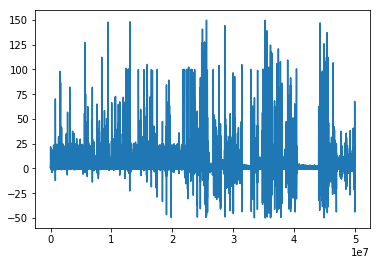

In [289]:
plt.plot(sparse_data)

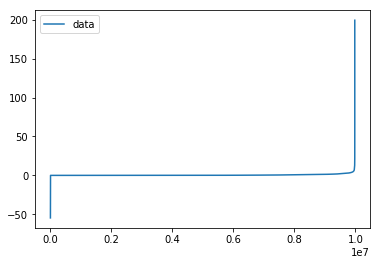

In [200]:
data_s.sort_values(by='data').reset_index()[['data']].plot()

### Row na dcolum sums

In [290]:
sparse_matrix.shape

(223341, 785608)

In [291]:
row_sums = sparse_matrix.sum(1)
col_sums = sparse_matrix.sum(0)

In [292]:
row_sums = pd.DataFrame(row_sums)
col_sums = pd.DataFrame(col_sums).T

In [293]:
row_sums.describe()

,0
count,223341.000000
mean,82.572935
std,32.521961
min,-46.569974
25%,82.049976
50%,98.659973
75%,99.999971
max,149.969958


In [294]:
col_sums.describe()

,0
count,785608.000000
mean,23.474712
std,478.320531
min,-5606.298244
25%,0.000000
50%,0.180000
75%,2.140000
max,116567.412152


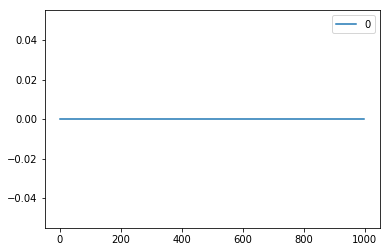

In [207]:
pd.DataFrame(sparse_matrix[35406,0:1000].todense()).T.plot()

## Sum of percent_tna per Fund/Date

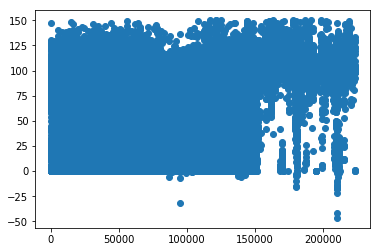

In [296]:
plt.plot(row_sums,'o')

## Observations per Stock

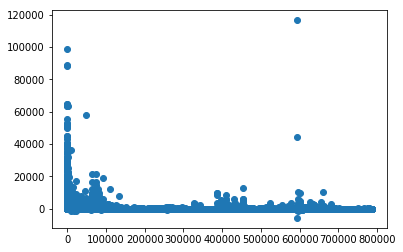

In [297]:
plt.plot(col_sums,'o')

### sparse_info

In [212]:
sparse_info.sample(5)

,port_no,date
26139,10008821,1983-01-12
27656,10009291,1977-12-13
22388,10007561,1978-05-15
38936,10013301,1978-02-12
19982,10006681,1982-10-12


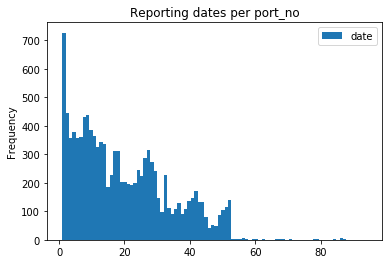

In [298]:
sparse_info.groupby('port_no').count().plot(kind='hist', bins=90, title= 'Reporting dates per port_no')